In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
from torchvision import models

In [0]:
import torchvision.transforms as transforms

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
print(device)

cuda:0


<h3>Loading Dataset and Applying Transforms </h3>

In [0]:
transforms_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

])

transforms_test = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

])




<b>Note : </b>transforms.Normalize does the following for each of the 3 channels: image = (image - mean) / std The parameters mean, std are passed as 0.5, 0.5 in your case. This will normalize the image in the range [-1,1]. For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to 1


<b> Steps in Image Preprocessing </b>

<ul>
  <li>Uniform aspect ratio : Most of the neural network models assume a square shape input image, which means that each image needs to be checked if it is a square or not, and cropped appropriately </li>
  <li> Image scaling </li>
  <li> Computing mean, std dev and normalizing inputs </li>
  <li> Data augmentation </li>

</ul>

https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258

In [7]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transforms_train)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transforms_train)

0it [00:00, ?it/s]

100%|█████████▉| 170074112/170498071 [00:14<00:00, 14707928.74it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
num_classes = 10

In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)


In [11]:
dataiter = iter(trainloader)

images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())


torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
6


Note: The original size of CIFAR image is 32 x 32, but using the RandomResizedCrop function we changed it to 224 x 224

In [12]:
len(trainloader)


12500

In [0]:
def imshow(img, title):
    # Unnormalize the image, we multiply by 0.5 that is the std deviation, and add 0.5 which is the mean
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    #Convert [3,224,224] to [224,224,3]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

    

In [0]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

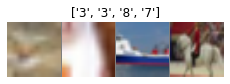

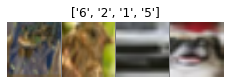

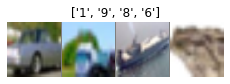

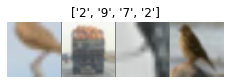

In [15]:
for i in range(4):
    show_batch_images(trainloader)

<h3> Using Pretrained Resnet and Transfer Learning </h3>

In [0]:
resnet = models.resnet18()

In [17]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
resnet = models.resnet18(pretrained= True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth

  0%|          | 0.00/44.7M [00:00<?, ?B/s]
 27%|██▋       | 11.9M/44.7M [00:00<00:00, 125MB/s]
 53%|█████▎    | 23.8M/44.7M [00:00<00:00, 125MB/s]
 79%|███████▉  | 35.4M/44.7M [00:00<00:00, 124MB/s]
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]

In [0]:
for param in resnet.parameters():
  param.requires_grad= False

# we have frozen the parameters by making gradients 0
# because weights are already pretrained on imagenet dataset


In [0]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes) # modifying last layer

In [21]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)# only last layer should be printed as gradients has been set to zero for all other layers

torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

In [0]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total


In [0]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


In [0]:
import copy # To store best intermediate models

Min loss 3.49
Iteration: 0/12500, Loss: 3.49
Min loss 0.80
Min loss 0.78
Min loss 0.45
Min loss 0.31
Iteration: 100/12500, Loss: 1.69
Min loss 0.23
Min loss 0.19
Iteration: 200/12500, Loss: 1.34
Iteration: 300/12500, Loss: 2.11
Iteration: 400/12500, Loss: 1.12
Iteration: 500/12500, Loss: 1.70
Iteration: 600/12500, Loss: 2.54
Iteration: 700/12500, Loss: 1.50
Iteration: 800/12500, Loss: 1.82
Iteration: 900/12500, Loss: 0.46
Iteration: 1000/12500, Loss: 2.55
Iteration: 1100/12500, Loss: 2.09
Min loss 0.16
Iteration: 1200/12500, Loss: 2.69
Iteration: 1300/12500, Loss: 2.59
Iteration: 1400/12500, Loss: 1.74
Iteration: 1500/12500, Loss: 1.12
Iteration: 1600/12500, Loss: 1.51
Iteration: 1700/12500, Loss: 2.11
Iteration: 1800/12500, Loss: 2.25
Iteration: 1900/12500, Loss: 3.41
Iteration: 2000/12500, Loss: 1.87
Iteration: 2100/12500, Loss: 1.34
Iteration: 2200/12500, Loss: 0.98
Iteration: 2300/12500, Loss: 1.81
Iteration: 2400/12500, Loss: 1.78
Iteration: 2500/12500, Loss: 1.64
Min loss 0.07
It

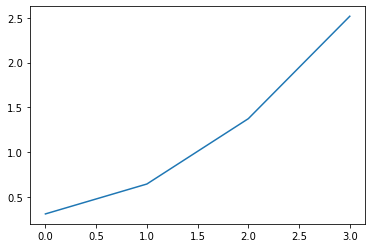

In [27]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [28]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

43.548 42.38
